# Reproducing the Sycamore Experiment - a Proof of Concept

In this notebook we reproduce one of the experiments conducted within Google's 2019 quantum supremacy Sycamore experiment.

## Scope and quantum software platforms

As a proof of concept, we begin with the most simple case where the number of qubits is $n = 12$ and the number of cycles is $m = 14$. For now and in this notebook, we use solely tools and platforms offered by Google, i.e the Python packages `cirq` and `qsimcirq`. For now we run the quantum circuits on a high-performance classical simulator only, i.e `QSimSimulator` - with and without artificially injected quantum noise.

A dedicated Python class, named `SycamoreExp` has been written with the goal to provide a simple API for our needs.

## Data

We use Google's experiment data which is available in https://datadryad.org/stash/dataset/doi:10.5061/dryad.k6t1rj8. For this notebook we use solely data of [June 13, 2022/n12_m14.tar.gz](https://datadryad.org/stash/downloads/file_stream/1549353)

## Mathematical tools

### Linear cross-entropy benchmarking fidelity:

$$\mathcal{F}_{XEB} = \big[2^n \sum^{2^n - 1}_{i\ =\ 0}p_iq_i \big] - 1 \tag{1}$$

$\mathcal{F}_{XEB}$ is used to assess the "similarity" between two probability distributions over the same sample space. $\mathcal{F}_{XEB} \approx 1$ indicates nearly identical probability distributions, while $\mathcal{F}_{XEB} \approx 0$ indicates completely different distributions.

When $P$ is the probability distribution of an ideal simulation of a quantum circuit, and $Q$ is the probability distribution of a noisy simulation of the same quantum circuit, then $\mathcal{F}_{XEB}$ (when $p_i \in P$ and $q_i \in Q$) can be used to assess the rate of noise involved in the simulation: $\mathcal{F}_{XEB} \approx 0$ indicates a completely decohered state.

### Porter-Thomas distribution:

Another tool to assess the rate of coherence regarding pseudo-random circuits. The pseudo-random circuits that have been tested in Google's experiment, should yield outcomes that obey Porter-Thomas distribution in ideal noiseless conditions. What it means is that the vast majority of the measured bitstrings should appear sparsely (low probability), and smaller numbers of bitstrings should appear many times (high probability).

The method is therefore as follows:
1. Scaling a probability distribution by the Hilbert space's dimension $dim(\mathcal{H}) = 2^n$.
2. Binning of the scaled probabilities into a histogram with some fixed number of bins.
3. Measuring the density of the outcomes.

In a Porter-Thomas distribution the density of the outcomes should fit an exponential decay curve $e^{-x}$. Quantum noise involved in the simulation causes the scaled probabilities distribution to deviate from the Porter-Thomas exponential decay form towards a uniformly distributed Gaussian-like form. Both cases are demonstrated in this notebook.

## Implementation

### Step 1 - Reconstructing the statevector

We begin by importing the quantum circuit (`cirq.Circuit`) object, as it has been provided by Google. Then we simulate its ideal final statevector and compare it to the amplitudes-data provided by Google in a form of a raw text file.

In [1]:
import numpy as np
import cirq
import qsimcirq

from n12_m14_s0_eo.circuit_n12_m14_s0_e0_pEFGH import CIRCUIT, QUBIT_ORDER
from sycamore_exp import SycamoreExp

num_qubits = 12
num_cycles = 14
data_file_path = "n12_m14_s0_eo/amplitudes_n12_m14_s0_e0_pEFGH.txt"
interface = SycamoreExp(name="try", num_qubits=num_qubits, num_cycles=num_cycles)

simulated_statevector = interface.circuit_ideal_amps(CIRCUIT)
statevector_probs = np.abs(simulated_statevector)**2
raw_df, curated_df = interface.data_file_to_df(data_file_path)

print(f"The exact probabilities calculated from the statevector: {statevector_probs}")
print()

print("The raw Google's amplitudes-data and its calculated probabilities:")
curated_df

The exact probabilites calculated from the statevector: [8.92195946e-06 5.80668555e-04 8.51136338e-05 ... 1.23330348e-04
 3.70480474e-04 1.09062334e-04]

The raw Google's amplitudes-data and its calculated probabilities:


,bitstring,real_amp,imag_amp,probs
7222,000000000000,0.001091,0.002781,0.000009
2867,000000000001,0.017359,-0.016713,0.000581
3582,000000000010,-0.008737,0.002962,0.000085
13784,000000000011,0.008198,0.012901,0.000234
1145,000000000100,0.010864,0.024643,0.000725
...,...,...,...,...
2366,111111111011,-0.008653,-0.020225,0.000484
3259,111111111100,0.007954,-0.000898,0.000064
6082,111111111101,-0.010784,-0.002652,0.000123
82,111111111110,-0.015668,-0.011180,0.000370


It can be seen that the raw data approximately fits the statevector. We verify:

In [2]:
np.allclose(statevector_probs, curated_df["probs"])

True

And we also compute $\mathcal{F}_{XEB}$ of the raw-data probabilities compared to the statevector's probabilities:

In [3]:
interface.compute_f_xeb(statevector_probs, curated_df["probs"])

1.0174852242671015

And indeed we get a value which is close to $1$. We now verify by plotting the scaled-probabilities distribution, for both the raw-data (1) and the statevector's calculated probabilities (2):

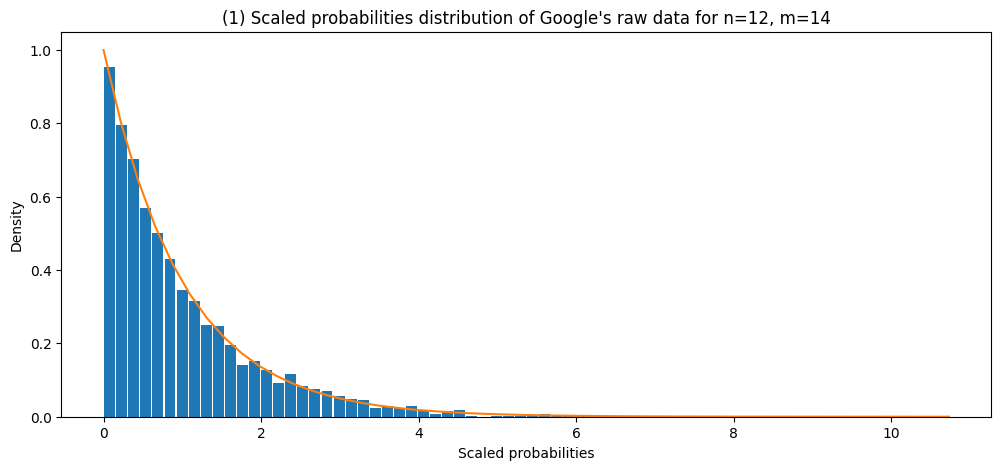

In [23]:
interface.draw_scaled_prb_dist(
    probs=curated_df["probs"],
    fig_title="(1) Scaled probabilities distribution of Google's raw data for n=12, m=14",
    exp_decay_plot=True
)

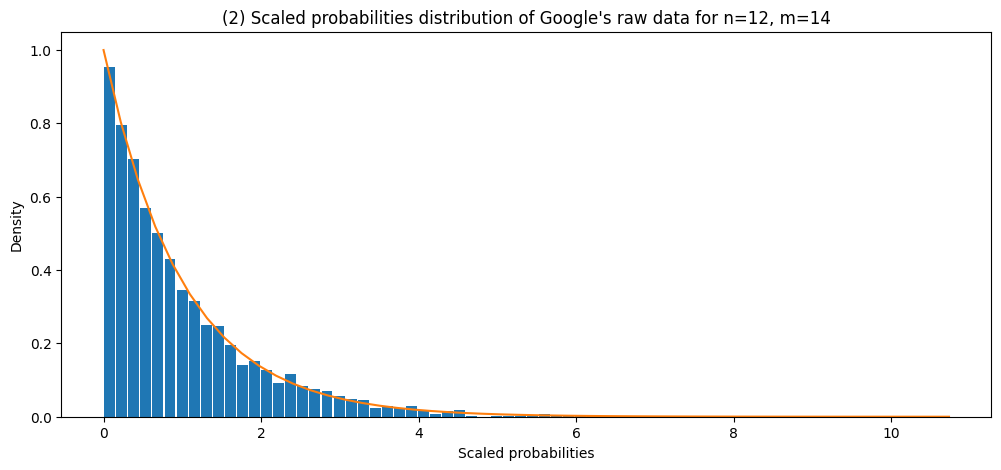

In [24]:
interface.draw_scaled_prb_dist(
    probs=statevector_probs,
    fig_title="(2) Scaled probabilities distribution of Google's raw data for n=12, m=14",
    exp_decay_plot=True
)

And indeed we get Porter-Thomas nice exponential decays for both cases.

### Step 2 - Simulating the circuit in noiseless ideal conditions

We now do the same with 500,000 shots in ideal noiseless conditions:

In [25]:
reps = 500_000
ideal_sim_results = interface.simulate(CIRCUIT, QUBIT_ORDER, qsimcirq.QSimSimulator(), reps)

ideal_sim_results.probs_vector

array([2.00e-06, 5.50e-04, 7.60e-05, ..., 1.46e-04, 3.64e-04, 1.06e-04])

Now it seems that the resulting probability distribution deviates from the ideal probabilities. So we verify:

In [26]:
np.allclose(ideal_sim_results.probs_vector, statevector_probs)

False

In [7]:
np.allclose(ideal_sim_results.probs_vector, statevector_probs, atol=1e-03)

True

Indeed, there is some deviation, but it looks that the probabilities are still somewhat close, because by lowering the tolerance we did get a truthy outcome.

So we verify by the $\mathcal{F}_{XEB}$ and Porter-Thomas tests:

In [8]:
interface.compute_f_xeb(ideal_sim_results.probs_vector, statevector_probs)

1.018903619912868

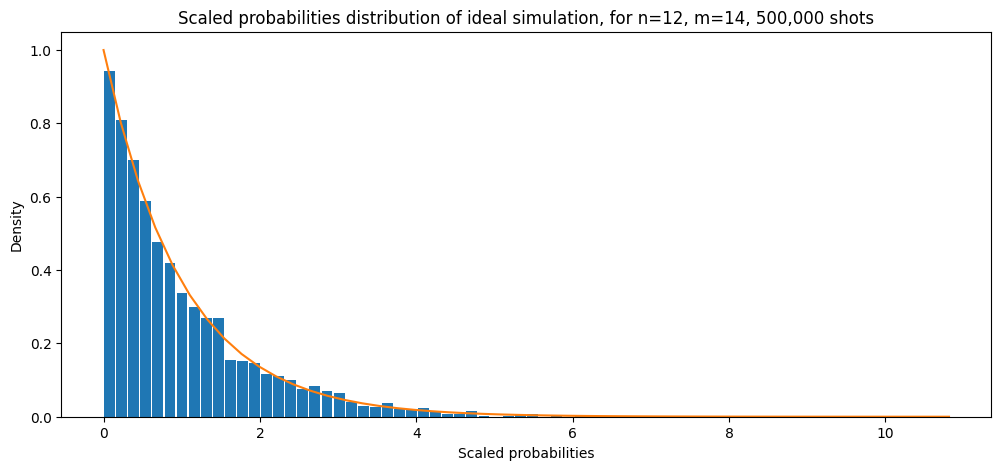

In [21]:
interface.draw_scaled_prb_dist(
    probs=ideal_sim_results.probs_vector,
    fig_title="Scaled-probabilities distribution of an ideal simulation, for n=12, m=14, 500,000 shots",
    exp_decay_plot=True
)

And indeed we get good results - $\mathcal{F}_{XEB} \approx 1$ and an exponential Porter-Thomas decay.

### Step 3 - Adding noise

We now do the same but with a noise model that injects a depolarizing channel with a probabilistic error $p_e = 0.0016$ between each pair of layers in the circuit:

In [27]:
noisy_qc = CIRCUIT.with_noise(cirq.depolarize(0.0016))
noisy_qc

┌──────────────────────────────────────────────────────────────────────────────┐                                                                                                                                                                           ┌──────────────────────────────────────────────────────────────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ┌──────────────────────────────────────────────────────────────────────────────┐                                                                                                                                                                           ┌──────────────────────────────────────────────────────────────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ┌──────────────────────────────────────────────────────────────────────────────┐                                                                                                                                                                           ┌──────────────────────────────────────────────────────────────────────────────┐
(3, 3): ───PhX(0.25)^0.5───D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]──────────────────────────D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]───Y^0.5───────────D(0.0016)[cirq.VirtualTag()]───Rz(-1.47π)────D(0.0016)[cirq.VirtualTag()]───FSim(0.412π, 0.155π)───D(0.0016)[cirq.VirtualTag()]───Rz(1.65π)─────D(0.0016)[cirq.VirtualTag()]───X^0.5───────────D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]──────────────────────────────────────────────────────────────────────────────────────D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]───PhX(0.25)^0.5───D(0.0016)[cirq.VirtualTag()]───Rz(0.704π)────D(0.0016)[cirq.VirtualTag()]────FSim(0.467π, 0.158π)──────────────────────────────────────────────────────────────D(0.0016)[cirq.VirtualTag()]───Rz(-0.477π)───D(0.0016)[cirq.VirtualTag()]───X^0.5───────────D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]──────────────────────────D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]───PhX(0.25)^0.5───D(0.0016)[cirq.VirtualTag()]───Rz(-0.435π)───D(0.0016)[cirq.VirtualTag()]───FSim(0.412π, 0.155π)───D(0.0016)[cirq.VirtualTag()]───Rz(0.622π)────D(0.0016)[cirq.VirtualTag()]───X^0.5───────────D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]──────────────────────────────────────────────────────────────────────────────────────D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]───PhX(0.25)^0.5───D(0.0016)[cirq.VirtualTag()]───Rz(-1.98π)────D(0.0016)[cirq.VirtualTag()]────FSim(0.467π, 0.158π)──────────────────────────────────────────────────────────────D(0.0016)[cirq.VirtualTag()]───Rz(-1.8π)─────D(0.0016)[cirq.VirtualTag()]───X^0.5───────────D(0.0016)[cirq.VirtualTag()]─────────────────D(0.0016)[cirq.VirtualTag()]──────────────────────────D(0.00

In [28]:
noisy_sim_res = interface.simulate(noisy_qc, QUBIT_ORDER, qsimcirq.QSimSimulator(), reps)
noisy_sim_res.probs_vector

array([0.000174, 0.000386, 0.00019 , ..., 0.000186, 0.000268, 0.000216])

Now it seems that the resulting probability distribution deviates heavily from the ideal probabilities. So we verify by calculating $\mathcal{F}_{XEB}$:

In [15]:
interface.compute_f_xeb(noisy_sim_res.probs_vector, statevector_probs)

0.36071494830800743

Indeed! $\mathcal{F}_{XEB}$ is now far from the ideal value of $1$, but still not in the completely decohered state (which corresponds to $\mathcal{F}_{XEB} \approx 0$). So we check the scaled-probabilities distribution:

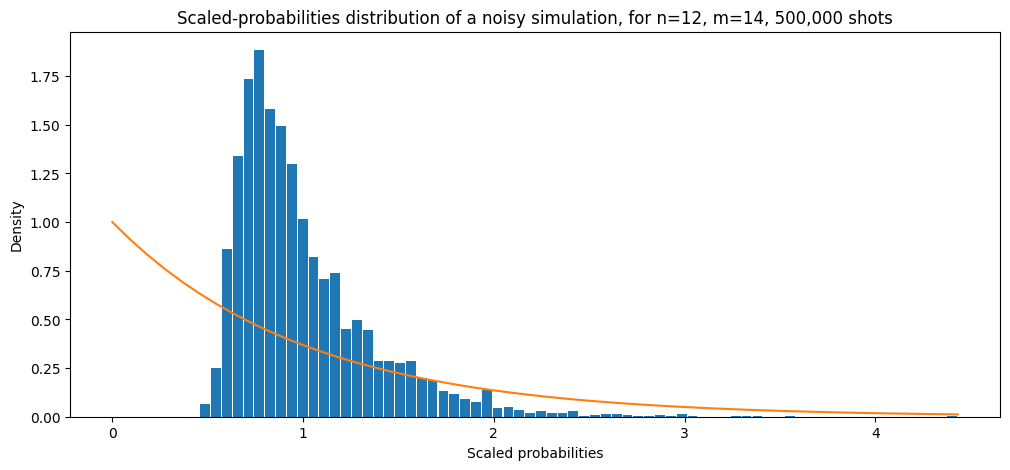

In [22]:
interface.draw_scaled_prb_dist(
    probs=noisy_sim_res.probs_vector,
    fig_title="Scaled-probabilities distribution of a noisy simulation, for n=12, m=14, 500,000 shots",
    exp_decay_plot=True
)

And now we see a significant deviation from the Porter-Thomas exponential decay.